gofasta vs amanual mutation calling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
hu1_gofasta_path = '/home/eleanor124/projects/bjorn_rep/output/Hu1/gofasta/mutations.tsv'
hu1_manual_path = '/home/eleanor124/projects/bjorn_rep/output/Hu1/mutations.tsv'
hu1_manual_mafft_path = '/home/eleanor124/projects/bjorn_rep/output/Hu1/mafft/mutations.tsv'

ba1_gofasta_path = '/home/eleanor124/projects/bjorn_rep/output/Hu1/gofasta/BA1/mutations.tsv'
ba1_manual_path = '/home/eleanor124/projects/bjorn_rep/output/Hu1/NC_045512.2_BA.1_mutations.tsv'
ba1_manual_mafft_path = '/home/eleanor124/projects/bjorn_rep/output/Hu1/mafft/NC_045512.2_BA.1_mutations.tsv'


ba2_gofasta_path = '/home/eleanor124/projects/bjorn_rep/output/Hu1/gofasta/BA2/mutations.tsv'
ba2_manual_path = '/home/eleanor124/projects/bjorn_rep/output/Hu1/NC_045512.2_BA.2_mutations.tsv'
ba2_manual_mafft_path = '/home/eleanor124/projects/bjorn_rep/output/Hu1/mafft/NC_045512.2_BA.2_mutations.tsv'


pb2_mut_path = '/home/eleanor124/projects/bjorn_rep/data/PB2-DMS/PB2_mut.tsv'
pb2_gofasta_path = '/home/eleanor124/projects/bjorn_rep/output/PB2/gofasta/mutations.tsv'
pb2_manual_path = '/home/eleanor124/projects/bjorn_rep/output/PB2/mutations.tsv'
pb2_manual_mafft_path = '/home/eleanor124/projects/bjorn_rep/output/PB2/mafft/mutations.tsv'

cy_gofasta_path = '/home/eleanor124/projects/bjorn_rep/output/PB2/gofasta/CY/mutations.tsv'
cy_manual_path = '/home/eleanor124/projects/bjorn_rep/output/PB2/CY018884.1_cds_ABM21959.1_1_mutations.tsv'
cy_manual_mafft_path = '/home/eleanor124/projects/bjorn_rep/output/PB2/mafft/CY018884.1_cds_ABM21959.1_1_mutations.tsv'


In [3]:
ambiguous_nuc = ['R', 'Y', 'W', 'S', 'K', 'M', 'B', 'D', 'H', 'V', 'N']

In [4]:
def process(path):
    df = pd.read_csv(path, sep="\t")
    df = (
        df[["sra", "region", "pos", "ref", "alt"]]
        .drop_duplicates()
        .sort_values(by=["sra", "pos"])
        .reset_index(drop=True)
    )

    return df


In [35]:
def corr_plt(gofasta, manual, title):

    gofasta1 = (
        gofasta.groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_standard")
    )

    manual2 = (
        manual[~manual["alt"].str.upper().isin(ambiguous_nuc)]
        .groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_manual")
    )
    
    merged2 = pd.merge(gofasta1, manual2, on='sra', how="outer").fillna(0)

    plt.scatter(merged2['pos_count_manual'], merged2['pos_count_standard'], color='lightblue')
    minv = min(merged2['pos_count_manual'])
    maxv = max(merged2['pos_count_manual'])
    
    plt.plot([minv, maxv], [minv, maxv], 'r--', label='y = x')
    plt.legend(loc='upper right')
    plt.xlabel("pos count - our mutation calling")
    plt.ylabel("pos count - standard")
    plt.title(f"Number of mutations in each position, excluding ambiguous nuc for ALT - {title}")
    plt.tight_layout()
    plt.show()

    return merged2[merged2['pos_count_standard'] != merged2['pos_count_manual']]


## Hu1-BA

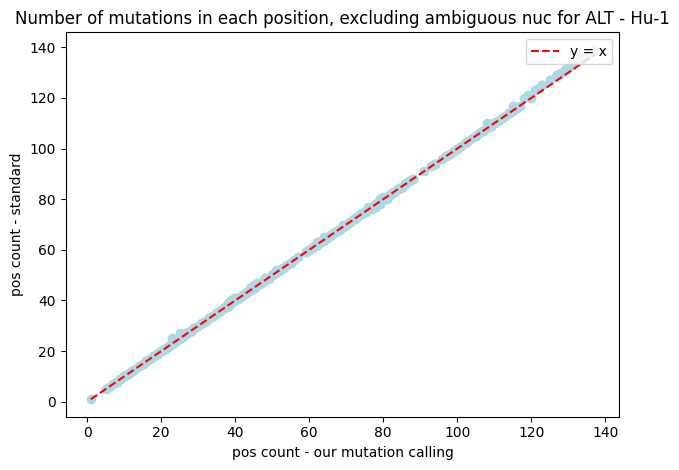

,sra,pos_count_standard,pos_count_manual,gap
288,hCoV-19/USA/CA-SEARCH-201359/2022,76,77,1
284,hCoV-19/USA/CA-SEARCH-201075/2022,77,78,1
316,hCoV-19/USA/CA-SEARCH-214489/2022,78,79,1
325,hCoV-19/USA/CA-SEARCH-219082/2022,80,81,1
313,hCoV-19/USA/CA-SEARCH-213047/2022,78,79,1
901,hCoV-19/USA/STM-EN8263XGH/2021,47,46,-1
794,hCoV-19/USA/STM-0007200-H10/2021,45,44,-1
946,hCoV-19/USA/STM-QF72HJ7XG/2022,81,80,-1
939,hCoV-19/USA/STM-NY8R7RPYP/2021,52,51,-1
758,hCoV-19/USA/STM-0000503-B02/2021,39,38,-1


In [29]:
hu1_gofasta = process(hu1_gofasta_path)
hu1_manual = process(hu1_manual_path)

pos_mismatch = corr_plt(hu1_gofasta, hu1_manual, "Hu-1")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
pos_mismatch.sort_values(by=["gap"], ascending=False)

In [ ]:
tmp1 = hu1_gofasta.loc[hu1_gofasta["sra"] == "hCoV-19/USA/CA-SEARCH-63567/2021", ]
tmp2 = hu1_manual.loc[(hu1_manual["sra"] == "hCoV-19/USA/CA-SEARCH-63567/2021") & (hu1_manual["alt"] != 'N'), ]
pd.merge(tmp1, tmp2, how="outer", on=['sra', 'pos'])

/tmp/ipykernel_175155/106381375.py:2: DtypeWarning: Columns (5,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep="\t")


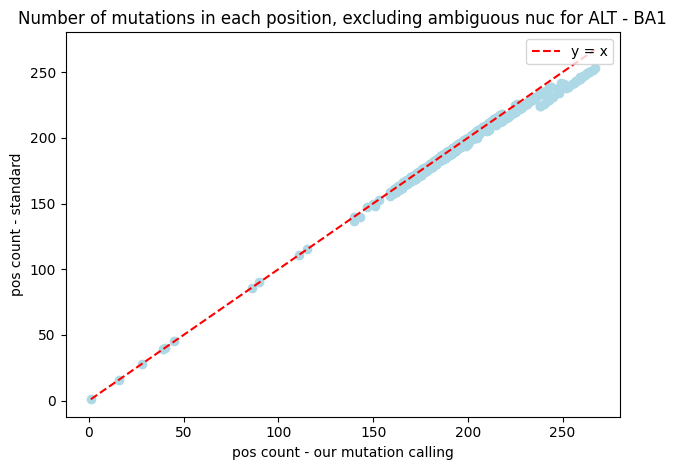

,sra,pos_count_standard,pos_count_manual,gap
353,hCoV-19/USA/CA-SEARCH-233687/2024,226,240,14
269,hCoV-19/USA/CA-SEARCH-140767/2024,248,262,14
275,hCoV-19/USA/CA-SEARCH-141359/2024,239,253,14
274,hCoV-19/USA/CA-SEARCH-141358/2024,253,267,14
273,hCoV-19/USA/CA-SEARCH-141236/2024,241,255,14
...,...,...,...,...
382,hCoV-19/USA/CA-SEARCH-53829/2021,193,196,3
381,hCoV-19/USA/CA-SEARCH-53764/2021,192,195,3
380,hCoV-19/USA/CA-SEARCH-53649/2021,191,194,3
379,hCoV-19/USA/CA-SEARCH-53470/2021,195,198,3


In [30]:
ba1_gofasta = process(ba1_gofasta_path)
ba1_manual = process(ba1_manual_path)

pos_mismatch = corr_plt(ba1_gofasta, ba1_manual, "BA1")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
pos_mismatch.sort_values(by=["gap"], ascending=False)

/tmp/ipykernel_175155/106381375.py:2: DtypeWarning: Columns (5,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep="\t")
/tmp/ipykernel_175155/106381375.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep="\t")


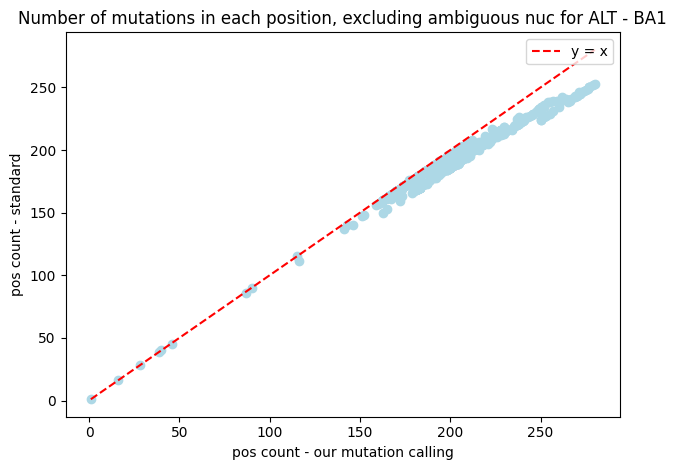

,sra,pos_count_standard,pos_count_manual,gap
269,hCoV-19/USA/CA-SEARCH-140767/2024,248,275,27
272,hCoV-19/USA/CA-SEARCH-141166/2024,252,279,27
274,hCoV-19/USA/CA-SEARCH-141358/2024,253,280,27
276,hCoV-19/USA/CA-SEARCH-141470/2024,246,273,27
277,hCoV-19/USA/CA-SEARCH-141694/2024,249,276,27
...,...,...,...,...
750,hCoV-19/USA/STM-0000123-G10/2021,178,181,3
670,hCoV-19/USA/SEARCH-15505/2021,176,179,3
856,hCoV-19/USA/STM-4YJ7JJW58/2022,45,46,1
760,hCoV-19/USA/STM-0000630-E04/2021,176,177,1


In [36]:
ba1_gofasta = process(ba1_gofasta_path)
ba1_manual_mafft = process(ba1_manual_mafft_path)

pos_mismatch = corr_plt(ba1_gofasta, ba1_manual_mafft, "BA1")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
pos_mismatch.sort_values(by=["gap"], ascending=False)

In [28]:
tmp1 = ba1_gofasta[(ba1_gofasta["sra"] == "hCoV-19/USA/CA-SEARCH-140651/2024") & (~ba1_gofasta["alt"].isin(ambiguous_nuc))]
tmp2 = ba1_manual[(ba1_manual["sra"] == 'hCoV-19/USA/CA-SEARCH-140651/2024') & (~ba1_manual["alt"].isin(ambiguous_nuc))]
m = pd.merge(tmp1, tmp2, how="outer", on=["pos"], indicator=True)
m[m["_merge"] != "both"]

,sra_x,region_x,pos,ref_x,alt_x,sra_y,region_y,ref_y,alt_y,_merge
73,hCoV-19/USA/CA-SEARCH-140651/2024,NC_045512.2_BA.1,22675,G,C,NaN,NaN,NaN,NaN,left_only
134,hCoV-19/USA/CA-SEARCH-140651/2024,NC_045512.2_BA.1,22929,T,-C,NaN,NaN,NaN,NaN,left_only
155,hCoV-19/USA/CA-SEARCH-140651/2024,NC_045512.2_BA.1,23008,C,G,NaN,NaN,NaN,NaN,left_only
239,NaN,NaN,22674,NaN,NaN,hCoV-19/USA/CA-SEARCH-140651/2024,NC_045512.2,C,T,right_only
240,NaN,NaN,22895,NaN,NaN,hCoV-19/USA/CA-SEARCH-140651/2024,NC_045512.2,G,C,right_only
241,NaN,NaN,22897,NaN,NaN,hCoV-19/USA/CA-SEARCH-140651/2024,NC_045512.2,C,T,right_only
242,NaN,NaN,22898,NaN,NaN,hCoV-19/USA/CA-SEARCH-140651/2024,NC_045512.2,T,A,right_only
243,NaN,NaN,22899,NaN,NaN,hCoV-19/USA/CA-SEARCH-140651/2024,NC_045512.2,C,G,right_only
244,NaN,NaN,22900,NaN,NaN,hCoV-19/USA/CA-SEARCH-140651/2024,NC_045512.2,A,T,right_only
245,NaN,NaN,22924,NaN,NaN,hCoV-19/USA/CA-SEARCH-140651/2024,NC_045512.2,T,A,right_only


In [32]:
tmp1 = ba1_gofasta[(ba1_gofasta["sra"] == "hCoV-19/USA/CA-SEARCH-233687/2024") & (~ba1_gofasta["alt"].isin(ambiguous_nuc))]
tmp2 = ba1_manual[(ba1_manual["sra"] == 'hCoV-19/USA/CA-SEARCH-233687/2024') & (~ba1_manual["alt"].isin(ambiguous_nuc))]
m = pd.merge(tmp1, tmp2, how="outer", on=["pos"], indicator=True)
m[m["_merge"] != "both"]

,sra_x,region_x,pos,ref_x,alt_x,sra_y,region_y,ref_y,alt_y,_merge
123,hCoV-19/USA/CA-SEARCH-233687/2024,NC_045512.2_BA.1,22929,T,-C,NaN,NaN,NaN,NaN,left_only
144,hCoV-19/USA/CA-SEARCH-233687/2024,NC_045512.2_BA.1,23008,C,G,NaN,NaN,NaN,NaN,left_only
226,NaN,NaN,22895,NaN,NaN,hCoV-19/USA/CA-SEARCH-233687/2024,NC_045512.2,G,C,right_only
227,NaN,NaN,22897,NaN,NaN,hCoV-19/USA/CA-SEARCH-233687/2024,NC_045512.2,C,T,right_only
228,NaN,NaN,22898,NaN,NaN,hCoV-19/USA/CA-SEARCH-233687/2024,NC_045512.2,T,A,right_only
229,NaN,NaN,22899,NaN,NaN,hCoV-19/USA/CA-SEARCH-233687/2024,NC_045512.2,C,G,right_only
230,NaN,NaN,22900,NaN,NaN,hCoV-19/USA/CA-SEARCH-233687/2024,NC_045512.2,A,T,right_only
231,NaN,NaN,22924,NaN,NaN,hCoV-19/USA/CA-SEARCH-233687/2024,NC_045512.2,T,A,right_only
232,NaN,NaN,22925,NaN,NaN,hCoV-19/USA/CA-SEARCH-233687/2024,NC_045512.2,C,T,right_only
233,NaN,NaN,22927,NaN,NaN,hCoV-19/USA/CA-SEARCH-233687/2024,NC_045512.2,T,G,right_only


In [ ]:
ba2_gofasta = process(ba2_gofasta_path)
ba2_manual = process(ba2_manual_path)

pos_mismatch = corr_plt(ba2_gofasta, ba2_manual, "BA2")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
pos_mismatch.sort_values(by=["gap"], ascending=False)

In [ ]:
tmp2 = ba2_manual[(ba2_manual["sra"] == 'hCoV-19/USA/STM-0007062-B10/2021') & (~ba2_manual["alt"].isin(ambiguous_nuc))]
tmp2

In [ ]:
tmp1 = ba1_manual.loc[ba1_manual["sra"] == "hCoV-19/Iraq/KR-SEARCH-119907/2021", ]
tmp2 = ba1_gofasta.loc[ba1_gofasta["sra"] == "hCoV-19/Iraq/KR-SEARCH-119907/2021", ]
m = pd.merge(tmp1, tmp2, on=["sra", "pos"], how="outer", indicator=True)
m[(m["_merge"]== "left_only")&(~m["alt_x"].isin(ambiguous_nuc))]

In [ ]:
tmp1 = ba1_gofasta.loc[ba1_gofasta["sra"] == "hCoV-19/Iraq/KR-SEARCH-118872/2021", ]
tmp2 = ba1_manual.loc[(ba1_manual["sra"] == "hCoV-19/Iraq/KR-SEARCH-118872/2021") & (ba1_manual["alt"] != 'N'), ]
merged_tmp = pd.merge(tmp1, tmp2, how="outer", on=['sra', 'pos'], indicator=True)
merged_tmp.loc[merged_tmp["_merge"] == 'left_only', :]

In [ ]:
corr_plt(ba2_gofasta, ba2_manual, "BA2")

In [ ]:
df1 = pd.read_csv('/home/eleanor124/projects/bjorn_rep/output/Hu1/mutations.tsv', sep="\t", header=0)
df1.sort_values(by=["sra", "pos"]).reset_index(drop=True, inplace=True)

df2 = pd.read_csv('/home/eleanor124/projects/bjorn_rep/output/Hu1/gofasta/BA1/mutations.tsv', sep="\t", header=0)
df2.sort_values(by=["sra", "pos"]).reset_index(drop=True, inplace=True)

df2

## PB2 - DMS

In [37]:
pb2_gofasta = process(pb2_gofasta_path)
pb2_gofasta["sra"] = pb2_gofasta["sra"].apply(lambda x: x.split('_')[1])
pb2_mut = process(pb2_mut_path)


pb2_manual= process(pb2_manual_path)
pb2_manual["sra"] = pb2_manual["sra"].apply(lambda x: x.split('_')[1])

pb2_manual_mafft = process(pb2_manual_mafft_path)
pb2_manual_mafft["sra"] = pb2_manual_mafft["sra"].apply(lambda x: x.split('_')[1])


In [ ]:
pb2_mut["sra"].nunique()

11458

In [18]:
pb2_manual["sra"].nunique()

11466

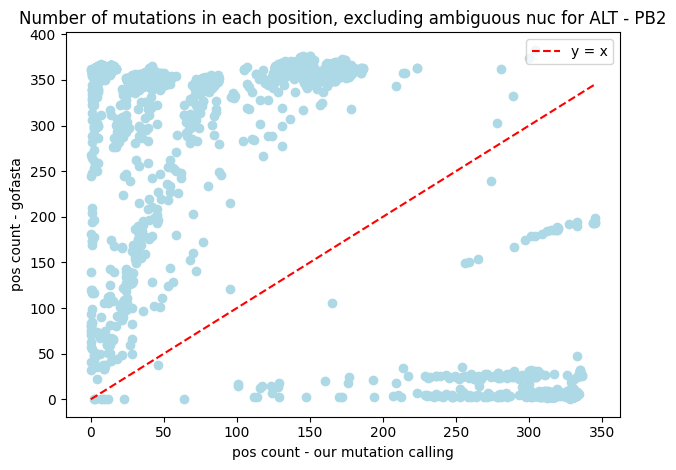

,sra,pos_count_gofasta,pos_count_manual,gap
58,SRR24839116,2.0,330.0,328.0
39,SRR24839097,2.0,330.0,328.0
240,SRR24839299,2.0,330.0,328.0
298,SRR24839357,4.0,332.0,328.0
299,SRR24839358,4.0,332.0,328.0
...,...,...,...,...
1689,SRR28912827,362.0,2.0,-360.0
2905,SRR30572420,362.0,2.0,-360.0
2625,SRR29953220,364.0,4.0,-360.0
1376,SRR28752509,361.0,0.0,-361.0


In [ ]:
pos_mismatch = corr_plt(pb2_mut, pb2_manual, "PB2")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
pos_mismatch.sort_values(by=["gap"], ascending=False)

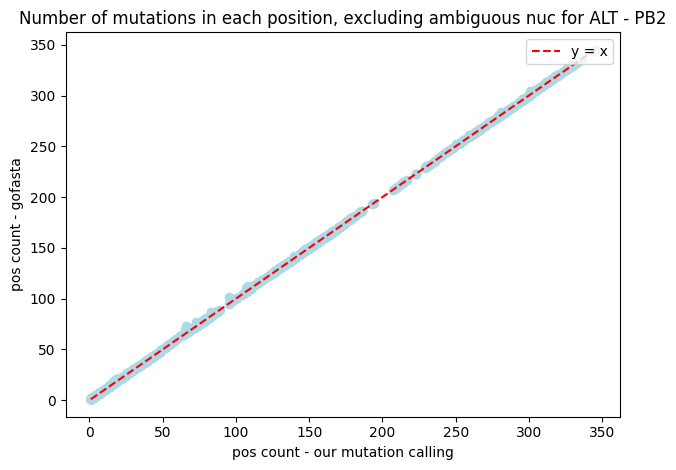

,sra,pos_count_gofasta,pos_count_manual
106,SRR24839164,231,230
172,SRR24839230,330,329
187,SRR24839245,162,161
206,SRR24839264,280,279
228,SRR24839286,304,301
...,...,...,...
11419,SRR35705808,22,21
11428,SRR35705817,28,27
11441,SRR35705831,60,59
11443,SRR35705833,19,17


In [ ]:
pos_mismatch = corr_plt(pb2_gofasta, pb2_manual, "PB2")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
pos_mismatch.sort_values(by=["gap"], ascending=False)
pos_mismatch

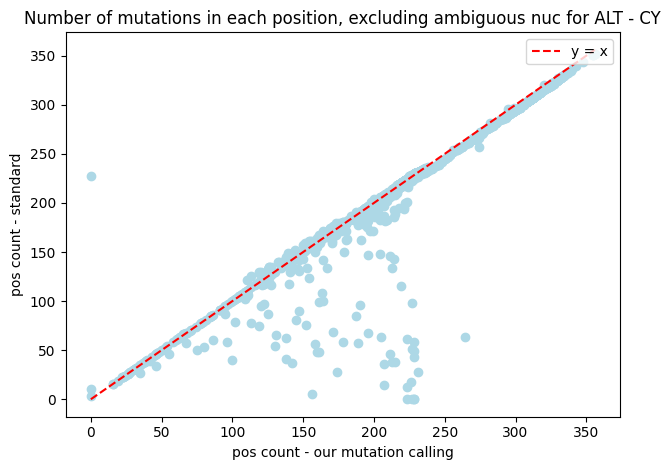

,sra,pos_count_standard,pos_count_manual,gap
0,SRR24839058,322.0,327.0,5.0
1,SRR24839059,322.0,327.0,5.0
2,SRR24839060,322.0,327.0,5.0
3,SRR24839061,319.0,324.0,5.0
4,SRR24839062,322.0,327.0,5.0
...,...,...,...,...
11462,SRR35705836,212.0,213.0,1.0
11465,SRR32513197,0.0,223.0,223.0
11466,SRR32653611,0.0,228.0,228.0
11467,SRR33125096,0.0,227.0,227.0


In [25]:
cy_manual = process(cy_manual_path)
cy_manual["sra"] = cy_manual["sra"].apply(lambda x: x.split('_')[1])
cy_gofasta = process(cy_gofasta_path)
cy_gofasta["sra"] = cy_gofasta["sra"].apply(lambda x: x.split('_')[1])

pos_mismatch = corr_plt(cy_gofasta, cy_manual, "CY")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
pos_mismatch.sort_values(by=["gap"], ascending=False)
pos_mismatch